In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def analyze_unannotated_videos(data_root):
    data_root = Path(data_root)
    unannotated_dir = data_root / "unannotated"
    
    video_stats = []
    
    for video_file in unannotated_dir.rglob("*/color.mp4"):
        try:
            cap = cv2.VideoCapture(str(video_file))
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = total_frames / fps if fps > 0 else 0
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            cap.release()
            
            video_stats.append({
                'video_id': video_file.parent.name,
                'date': video_file.parent.parent.name,
                'fps': fps,
                'duration': duration,
                'resolution': f"{width}x{height}",
                'total_frames': total_frames,
                'path': str(video_file)
            })
            
        except Exception as e:
            print(f"Error processing {video_file}: {str(e)}")
    
    return pd.DataFrame(video_stats)


In [12]:

def analyze_motion(video_path):
    cap = cv2.VideoCapture(str(video_path))
    ret, prev_frame = cap.read()
    if not ret:
        return {'mean_motion': 0, 'motion_variance': 0}
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    motion_levels = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(gray, prev_gray)
        motion_levels.append(np.mean(frame_diff))
        prev_gray = gray
    
    cap.release()
    return {
        'mean_motion': np.mean(motion_levels) if motion_levels else 0,
        'motion_variance': np.var(motion_levels) if motion_levels else 0
    }

In [13]:

def analyze_background(video_path):
    cap = cv2.VideoCapture(str(video_path))
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50)
    fg_pixels = []
    frame_size = None
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_size is None:
            frame_size = frame.shape[:2]  # Store frame dimensions
            
        fg_mask = bg_subtractor.apply(frame)
        fg_pixels.append(np.count_nonzero(fg_mask))
    
    cap.release()
    
    if not fg_pixels or frame_size is None:
        return {'foreground_ratio': 0}
    
    return {
        'foreground_ratio': np.mean(fg_pixels)/(frame_size[0]*frame_size[1])
    }

In [14]:


def visualize_unannotated_analysis(df):
    plt.figure(figsize=(15,10))
    
    # 1. Duration distribution
    plt.subplot(2,2,1)
    sns.histplot(df['duration'], bins=20)
    plt.title("Video Duration Distribution")
    
    # 2. Motion analysis
    plt.subplot(2,2,2)
    sns.scatterplot(data=df, x='duration', y='mean_motion')
    plt.title("Activity Level vs Duration")
    
    # 3. Foreground coverage
    plt.subplot(2,2,3)
    sns.boxplot(data=df, y='foreground_ratio')
    plt.title("Foreground Coverage")
    
    # 4. Resolution distribution
    plt.subplot(2,2,4)
    df['resolution'].value_counts().plot(kind='bar')
    plt.title("Video Resolutions")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('unannotated_analysis.png')
    plt.show()


Analyzing unannotated videos...
Calculating motion statistics...
Calculating foreground ratios...
Generating visualizations...


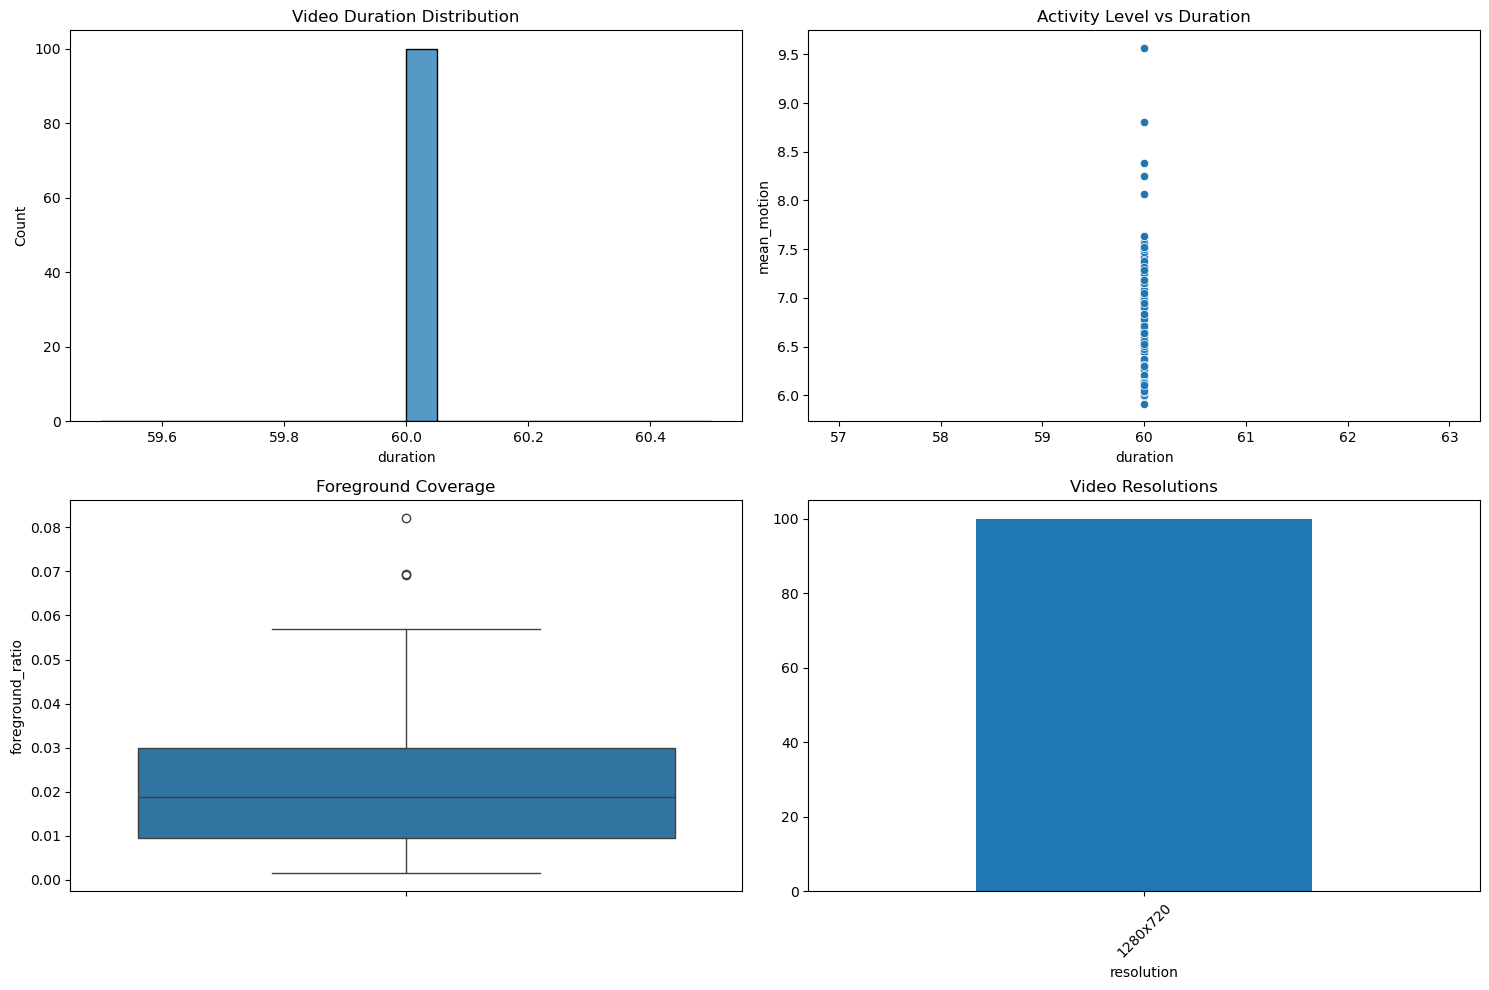

Saving results...
Analysis complete! Results saved to:
- unannotated_analysis.png (visualizations)
- unannotated_video_analysis.csv (raw data)


In [ ]:

# Main analysis pipeline
DATA_ROOT = r"C:\Users\2955352g\Desktop\pig_data_edinburgh"
unannotated_dir = Path(DATA_ROOT) / "unannotated"

print("Analyzing unannotated videos...")
unannotated_df = analyze_unannotated_videos(DATA_ROOT)

print("Calculating motion statistics...")
motion_stats = [analyze_motion(f) for f in unannotated_dir.rglob("*/color.mp4")]
unannotated_df = unannotated_df.join(pd.DataFrame(motion_stats))

print("Calculating foreground ratios...")
fg_stats = [analyze_background(f) for f in unannotated_dir.rglob("*/color.mp4")]
unannotated_df = unannotated_df.join(pd.DataFrame(fg_stats))

print("Generating visualizations...")
visualize_unannotated_analysis(unannotated_df)

print("Saving results...")
unannotated_df.to_csv('unannotated_video_analysis.csv', index=False)
print("Analysis complete! Results saved to:")
print("- unannotated_analysis.png (visualizations)")
print("- unannotated_video_analysis.csv (raw data)")